Geleneksel Derin Öğrenme (Deep Learning) modelleri "veri oburudur". Örneğin, bir yapay sinir ağının bir kediyi tanıması için binlerce kedi fotoğrafına ihtiyacı vardır. Ancak bir insan çocuğuna tek bir "bu bir kedi" fotoğrafı gösterdiğinizde, çocuk hayatı boyunca kediyi tanıyabilir.

Sorun: Her problem için binlerce etiketli veri bulmak imkansız veya çok pahalıdır (örn: nadir görülen tıbbi hastalıklar).

Çözüm: İnsan beyninin yaptığı gibi, önceki bilgilerden yararlanarak az sayıda örnekle yeni kavramları öğrenmek.

# Few Shot Learning Nedir?

Few Shot Learning (FSL), bir makine öğrenmesi modelinin son derece az sayıda örnekle, yeni sınıfları öğrenebilmesini amaçlayan bir öğrenme paradigmasıdır. Geleneksel derin öğrenme modelleri binlerce örnek gerektirirken, Few Shot Learning aşağıdaki tür görevlerde büyük önem taşır:
- Etiketleme maliyetinin yüksek olduğu alanlar
- Nadir görülen sınıfların bulunduğu veri setleri
- Veri toplamanın zor olduğu tıp, biyoloji, güvenlik gibi sektörler
- Gerçek zamanlı ve hızlı adaptasyon gerektiren uygulamalar

Few Shot Learning çoğu zaman şu şekilde ifade edilir:
- N-way K-shot öğrenme
- N: Görevdeki sınıf sayısı
- K: Her sınıf için sağlanan örnek (destek) sayısı

# Few Shot Learning’in Genel Çalışma Süreci

Few Shot Learning görevleri genellikle şu aşamalardan oluşur:

1. Support Set İşlenmesi

Destek seti örnekleri modele verilerek embedding’ler çıkarılır.
Her sınıf için bir temsil (örneğin sınıf prototipi) oluşturulur.

2. Query Set İşlenmesi

Sorgu örnekleri embedding’e dönüştürülür.

3. Mesafe Hesaplama

Query embedding’i ile support/prototip embedding’leri arasındaki mesafe hesaplanır:
- Öklid uzaklığı
- Kosinüs benzerliği
- Öğrenilebilir mesafe fonksiyonları

4. Tahmin

Query örneği en yakın olduğu sınıfın etiketiyle eşleştirilir.

Bu süreç eğitim verisinden bağımsız olarak yürütüldüğü için, model yeni sınıflarla karşılaştığında dahi iyi genelleme yapabilir.

# Few-Shot Learning'in Uygulanması

Bu çalışma:
- Basit bir embedding modeli (küçük CNN) tanımlar,
- MNIST üzerinde N-way K-shot epizodlar üretir,
- Prototipler üzerinden mesafe tabanlı loss ile meta-eğitim yapar,
- Eğitilmiş modeli few-shot görevlerde değerlendirir.

In [1]:
# Kütüphanelerin import edilmesi
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cpu


In [2]:
# Veri yükleme ve sınıf bazlı organizasyon
transform = transforms.Compose([
    transforms.ToTensor(),
    # [0,255] -> [0.,1.]
])

# MNIST eğitim verisi
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Sınıf bazında listeleme (örnek: class_images[3] -> sınıf 3'ün tüm tensörleri)
class_images = {i: [] for i in range(10)}
for img, label in train_dataset:
    class_images[int(label)].append(img)

# Her sınıf için kaç örnek olduğunu göster
for k in range(10):
    print(f"Sınıf {k} örnek sayısı: {len(class_images[k])}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 88.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 17.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 97.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.58MB/s]


Sınıf 0 örnek sayısı: 5923
Sınıf 1 örnek sayısı: 6742
Sınıf 2 örnek sayısı: 5958
Sınıf 3 örnek sayısı: 6131
Sınıf 4 örnek sayısı: 5842
Sınıf 5 örnek sayısı: 5421
Sınıf 6 örnek sayısı: 5918
Sınıf 7 örnek sayısı: 6265
Sınıf 8 örnek sayısı: 5851
Sınıf 9 örnek sayısı: 5949


In [3]:
# Basit embedding modeli
class Embedder(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 14x14 -> 7x7
        )
        self.fc = nn.Linear(64 * 7 * 7, out_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Modeli oluşturuyoruz ve cihaza gönderiyoruz.
model = Embedder(out_dim=64).to(device)
print(model)

Embedder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=64, bias=True)
)


In [4]:
# Episode oluşturucu
def create_episode(class_images, N=3, K=1, Q=5, seed=None):
    """
    class_images: sınıf->list of tensors
    N: kaç sınıf seçilecek (N-way)
    K: destek örnek sayısı (K-shot)
    Q: sorgu örnek sayısı (her sınıf için)
    """
    if seed is not None:
        random.seed(seed)
    classes = random.sample(list(class_images.keys()), N)

    support_imgs = []
    support_labels = []
    query_imgs = []
    query_labels = []

    for i, cls in enumerate(classes):
        # rastgele K+Q örnek seçiyoruz
        imgs = random.sample(class_images[cls], K + Q)
        support_imgs.extend(imgs[:K])
        query_imgs.extend(imgs[K:])
        support_labels.extend([i] * K)
        # Etiketler 0..N-1 olacak
        query_labels.extend([i] * Q)

    # Stack -> (N*K, C, H, W) ve (N*Q, C, H, W)
    support = torch.stack(support_imgs).to(device)
    query = torch.stack(query_imgs).to(device)
    support_labels = torch.tensor(support_labels, dtype=torch.long, device=device)
    query_labels = torch.tensor(query_labels, dtype=torch.long, device=device)

    return support, support_labels, query, query_labels

# Test yaparak devam edelim
support, s_labels, query, q_labels = create_episode(class_images, N=3, K=1, Q=3, seed=1)
print("Support shape:", support.shape, "Support labels:", s_labels)
print("Query shape:", query.shape, "Query labels:", q_labels)

Support shape: torch.Size([3, 1, 28, 28]) Support labels: tensor([0, 1, 2])
Query shape: torch.Size([9, 1, 28, 28]) Query labels: tensor([0, 0, 0, 1, 1, 1, 2, 2, 2])


In [5]:
# Prototip ve mesafe hesaplama yardımcıları oluşturucu
def compute_prototypes(embeddings, labels, N, K):
    """
    embeddings: (N*K, D)
    labels: (N*K,) değerleri 0..N-1
    döndürür: prototypes (N, D)
    """
    D = embeddings.size(-1)
    prototypes = torch.zeros(N, D, device=embeddings.device)
    for c in range(N):
        prototypes[c] = embeddings[labels == c].mean(dim=0)
    return prototypes

def pairwise_distances(x, y):
    """
    x: (m, d), y: (n, d)
    döndürür: (m, n) matrisi; burada squared euclidean distance
    """
    m, d = x.size()
    n, _ = y.size()
    # (m,1,d) ile (1,n,d) çıkarma -> (m,n,d)
    x_exp = x.unsqueeze(1).expand(m, n, d)
    y_exp = y.unsqueeze(0).expand(m, n, d)
    return torch.pow(x_exp - y_exp, 2).sum(dim=2)
    # (m,n)

In [6]:
# Tek episode eğitim adımı
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_episode(model, optimizer, class_images, N=5, K=1, Q=5):
    model.train()
    support, s_labels, query, q_labels = create_episode(class_images, N=N, K=K, Q=Q)
    # Embedding çıkar
    s_emb = model(support)
    # (N*K, D)
    q_emb = model(query)
    # (N*Q, D)

    # Prototipler
    prototypes = compute_prototypes(s_emb, s_labels, N, K)  # (N, D)

    # Query - prototype mesafeleri
    dists = pairwise_distances(q_emb, prototypes)
    # (N*Q, N)
    # Logitleri negatif mesafe olarak alıp crossentropy kullan (bigger logit -> daha yakın)
    logits = -dists
    loss = F.cross_entropy(logits, q_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Eğitim sırasında doğruluğu hesaplayalım
    preds = torch.argmin(dists, dim=1)
    acc = (preds == q_labels).float().mean().item()
    return loss.item(), acc

In [7]:
# Eğitim döngüsü (meta-train)
num_episodes = 1000
N_way = 5
K_shot = 1
Q_query = 5

losses = []
accs = []

for ep in tqdm(range(1, num_episodes + 1)):
    loss, acc = train_episode(model, optimizer, class_images, N=N_way, K=K_shot, Q=Q_query)
    losses.append(loss)
    accs.append(acc)
    if ep % 100 == 0:
        print(f"Episode {ep:04d} - Loss: {np.mean(losses[-100:]):.4f}, Acc: {np.mean(accs[-100:]):.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0100 - Loss: 1.8802, Acc: 0.7300
Episode 0200 - Loss: 0.7343, Acc: 0.8452
Episode 0300 - Loss: 0.7608, Acc: 0.8556
Episode 0400 - Loss: 0.4274, Acc: 0.9024
Episode 0500 - Loss: 0.5094, Acc: 0.8856
Episode 0600 - Loss: 0.4667, Acc: 0.8952
Episode 0700 - Loss: 0.2815, Acc: 0.9280
Episode 0800 - Loss: 0.1998, Acc: 0.9444
Episode 0900 - Loss: 0.2193, Acc: 0.9372
Episode 1000 - Loss: 0.1658, Acc: 0.9468


In [8]:
# Basit değerlendirme
def evaluate(model, class_images, episodes=200, N=5, K=1, Q=10):
    model.eval()
    accs = []
    with torch.no_grad():
        for _ in range(episodes):
            support, s_labels, query, q_labels = create_episode(class_images, N=N, K=K, Q=Q)
            s_emb = model(support)
            q_emb = model(query)
            prototypes = compute_prototypes(s_emb, s_labels, N, K)
            dists = pairwise_distances(q_emb, prototypes)
            preds = torch.argmin(dists, dim=1)
            accs.append((preds == q_labels).float().mean().item())
    return np.mean(accs), np.std(accs)

mean_acc, std_acc = evaluate(model, class_images, episodes=200, N=N_way, K=K_shot, Q=10)
print(f"Değerlendirme — Ortalama doğruluk: {mean_acc:.4f} ± {std_acc:.4f}")

Değerlendirme — Ortalama doğruluk: 0.9418 ± 0.0621


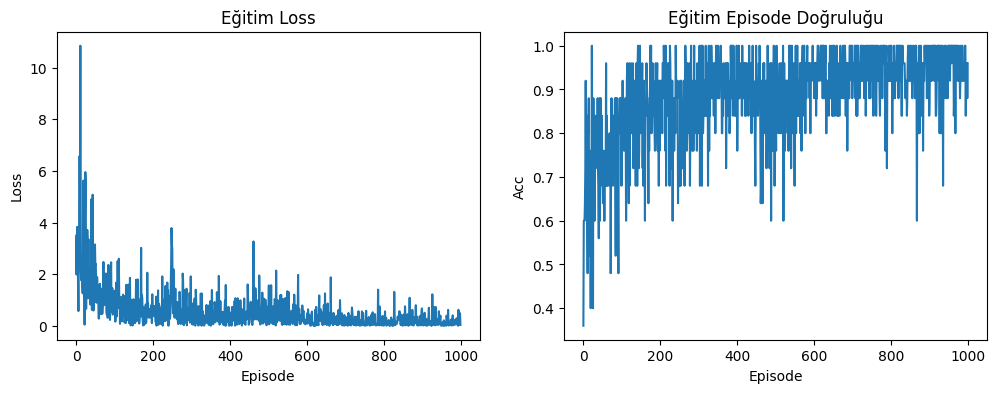

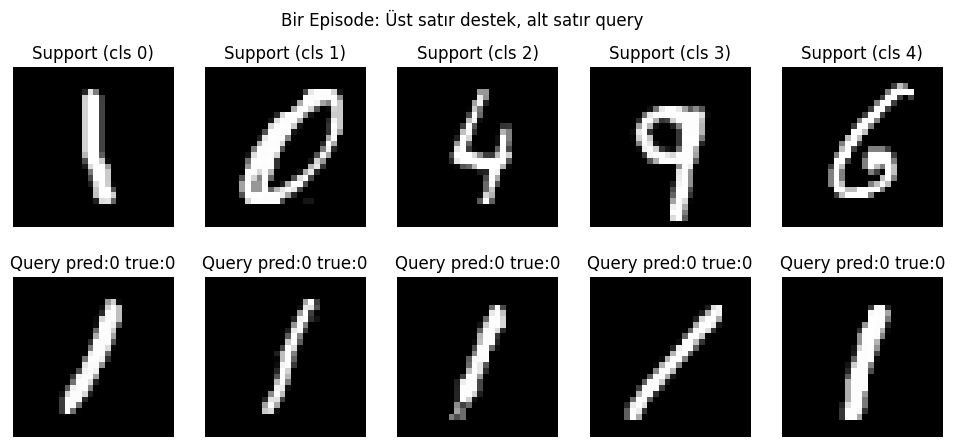

In [9]:
# Kayıp ve doğruluk grafiği
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Eğitim Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(accs)
plt.title("Eğitim Episode Doğruluğu")
plt.xlabel("Episode")
plt.ylabel("Acc")
plt.show()

# Bir örnek episode destek ve query görüntülerini görselleştirme
support, s_labels, query, q_labels = create_episode(class_images, N=5, K=1, Q=5, seed=42)
with torch.no_grad():
    s_emb = model(support)
    q_emb = model(query)
    prototypes = compute_prototypes(s_emb, s_labels, N=5, K=1)
    dists = pairwise_distances(q_emb, prototypes)
    preds = torch.argmin(dists, dim=1)

# Görüntüleri göster
fig, axes = plt.subplots(2,5, figsize=(12,5))
for i in range(5):
    axes[0,i].imshow(support[i].cpu().squeeze(), cmap='gray')
    axes[0,i].set_title(f"Support (cls {s_labels[i].item()})")
    axes[0,i].axis('off')

for i in range(5):
    axes[1,i].imshow(query[i].cpu().squeeze(), cmap='gray')
    axes[1,i].set_title(f"Query pred:{preds[i].item()} true:{q_labels[i].item()}")
    axes[1,i].axis('off')
plt.suptitle("Bir Episode: Üst satır destek, alt satır query")
plt.show()